In [1]:
from __future__ import division

from teext_network import (build_segmenter_simple, build_segmenter_upsample, build_segmenter_jet,
                              preproc_dataset)
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join
import matplotlib.pyplot as plt
import cv2
import random
import utool as ut
from itertools import product
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'fbannot_te_128'
dset_loc = 'TEST_fbannot_te_128'

In [3]:

model_name = 'model.pkl'
model = ut.load_cPkl(join(dataset_loc, "Flukes/patches/%s" % join(model_loc, model_name)))

dset = load_dataset(join(dataset_loc, "Flukes/patches/%s" % dset_loc), normalize_method='zscore')

[util_io] * load_cPkl(u'.../fbannot_te_128/model.pkl')
Loading /home/zach/data/Flukes/patches/TEST_fbannot_te_128
[util_io] * load_cPkl(u'.../TEST_fbannot_te_128/meanstd.pkl')
[util_io] * load_cPkl(u'.../TEST_fbannot_te_128/train.pkl')
[util_io] * load_cPkl(u'.../TEST_fbannot_te_128/val.pkl')
[util_io] * load_cPkl(u'.../TEST_fbannot_te_128/test.pkl')
Took 0.01 seconds


In [4]:
X = T.tensor4()


segmenter = build_segmenter_jet()
ll.set_all_param_values(segmenter, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(segmenter)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
segmenter_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:segmenter_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(segmenter)],ll.get_all_params(segmenter))))

[(0, ((2.2447562, (32, 1, 3, 3)), conv1_1.W)),
 (1, ((0.56074262, (32,)), conv1_1.b)),
 (2, ((5.8149605, (64, 32, 3, 3)), conv1_2.W)),
 (3, ((0.42924809, (64,)), conv1_2.b)),
 (4, ((8.1962595, (128, 64, 3, 3)), conv2_1.W)),
 (5, ((0.33076817, (128,)), conv2_1.b)),
 (6, ((8.2035217, (128, 128, 3, 3)), conv2_2.W)),
 (7, ((0.26532727, (128,)), conv2_2.b)),
 (8, ((8.1849308, (128, 128, 3, 3)), conv3_1.W)),
 (9, ((0.10881633, (128,)), conv3_1.b)),
 (10, ((8.1855803, (128, 128, 3, 3)), conv3_2.W)),
 (11, ((0.15644801, (128,)), conv3_2.b)),
 (12, ((8.1704025, (128, 128, 3, 3)), conv4_1.W)),
 (13, ((0.13535602, (128,)), conv4_1.b)),
 (14, ((8.1731253, (128, 128, 3, 3)), conv4_2.W)),
 (15, ((0.23729797, (128,)), conv4_2.b)),
 (16, ((1.2265804, (2, 128, 3, 3)), conv_8xpred.W)),
 (17, ((0.44003209, (2,)), conv_8xpred.b)),
 (18, ((1.1566195, (2, 128, 3, 3)), conv_4xpred.W)),
 (19, ((0.25416175, (2,)), conv_4xpred.b)),
 (20, ((1.1875347, (2, 128, 3, 3)), conv_2xpred.W)),
 (21, ((0.30633429, (2,)), 

In [6]:
[(ind, i.shape[1:], np.average(np.std(i,axis=0)), l.name) for (ind, i), l in zip(enumerate(point_outputs['valid']),ll.get_all_layers(segmenter))]

[(0, (1, 128, 128), 0.93007129, 'input'),
 (1, (32, 128, 128), 0.18459436, 'conv1_1'),
 (2, (64, 128, 128), 0.12446391, 'conv1_2'),
 (3, (64, 64, 64), 0.13085802, 'mp1'),
 (4, (128, 64, 64), 0.098946124, 'conv2_1'),
 (5, (128, 64, 64), 0.11101974, 'conv2_2'),
 (6, (128, 32, 32), 0.11400914, 'mp2'),
 (7, (128, 32, 32), 0.11649524, 'conv3_1'),
 (8, (128, 32, 32), 0.12836938, 'conv3_2'),
 (9, (128, 16, 16), 0.13377108, 'mp3'),
 (10, (128, 16, 16), 0.10733002, 'conv4_1'),
 (11, (128, 16, 16), 0.086378261, 'conv4_2'),
 (12, (2, 16, 16), 0.96222472, 'conv_8xpred'),
 (13, (2, 16, 16), 0.0065652006, '4dsoftmax_8x'),
 (14, (2, 128, 128), 0.0065652011, 'upsample_8x'),
 (15, (2, 32, 32), 1.3369987, 'conv_4xpred'),
 (16, (2, 32, 32), 0.012980412, '4dsoftmax_4x'),
 (17, (2, 32, 32), 0.0065652011, 'upsample_4x_pre'),
 (18, (2, 32, 32), 0.009423797, 'softmax_4_merge'),
 (19, (2, 128, 128), 0.009423797, 'upsample_4x'),
 (20, (2, 64, 64), 1.4379311, 'conv_2xpred'),
 (21, (2, 64, 64), 0.011891364, '4dso

In [7]:
print(np.average(point_outputs['valid'][23],axis=0))

[[[  1.61231402e-02   5.66742057e-03   2.85337470e-03 ...,   3.54070356e-03
     7.29676709e-03   1.57849640e-02]
  [  4.79574315e-03   3.34540964e-03   1.28844753e-03 ...,   2.63894000e-03
     5.68941049e-03   7.58404518e-03]
  [  1.89238170e-03   1.31009531e-03   9.21822037e-04 ...,   2.94180727e-03
     4.07722266e-03   5.86891593e-03]
  ..., 
  [  3.28753376e-03   1.95185351e-03   1.70189387e-03 ...,   7.75611610e-04
     1.12440321e-03   2.22960953e-03]
  [  6.72505656e-03   4.79954900e-03   1.87887042e-03 ...,   1.09622488e-03
     2.99638254e-03   4.56928741e-03]
  [  1.64127089e-02   7.86754489e-03   4.15629661e-03 ...,   2.54879124e-03
     5.18588675e-03   1.35553237e-02]]

 [[  9.83876646e-01   9.94332671e-01   9.97146487e-01 ...,   9.96459365e-01
     9.92702961e-01   9.84214962e-01]
  [  9.95204329e-01   9.96654689e-01   9.98711467e-01 ...,   9.97360766e-01
     9.94310617e-01   9.92415667e-01]
  [  9.98107433e-01   9.98689771e-01   9.99078214e-01 ...,   9.97058153e-01
  

[[[ 0.00907805  0.9909218 ]
  [ 0.00907805  0.9909218 ]
  [ 0.00279304  0.99720681]
  ..., 
  [ 0.00119351  0.99880636]
  [ 0.00151765  0.99848223]
  [ 0.00151765  0.99848223]]

 [[ 0.00907805  0.9909218 ]
  [ 0.00907805  0.9909218 ]
  [ 0.00279304  0.99720681]
  ..., 
  [ 0.00119351  0.99880636]
  [ 0.00151765  0.99848223]
  [ 0.00151765  0.99848223]]

 [[ 0.00263906  0.99736083]
  [ 0.00263906  0.99736083]
  [ 0.00216487  0.99783498]
  ..., 
  [ 0.00117577  0.99882412]
  [ 0.00117903  0.99882084]
  [ 0.00117903  0.99882084]]

 ..., 
 [[ 0.0029997   0.99700016]
  [ 0.0029997   0.99700016]
  [ 0.00186789  0.99813199]
  ..., 
  [ 0.0031085   0.99689138]
  [ 0.00485561  0.99514425]
  [ 0.00485561  0.99514425]]

 [[ 0.01137068  0.98862916]
  [ 0.01137068  0.98862916]
  [ 0.00270854  0.99729133]
  ..., 
  [ 0.00457748  0.99542236]
  [ 0.01550679  0.98449308]
  [ 0.01550679  0.98449308]]

 [[ 0.01137068  0.98862916]
  [ 0.01137068  0.98862916]
  [ 0.00270854  0.99729133]
  ..., 
  [ 0.00457

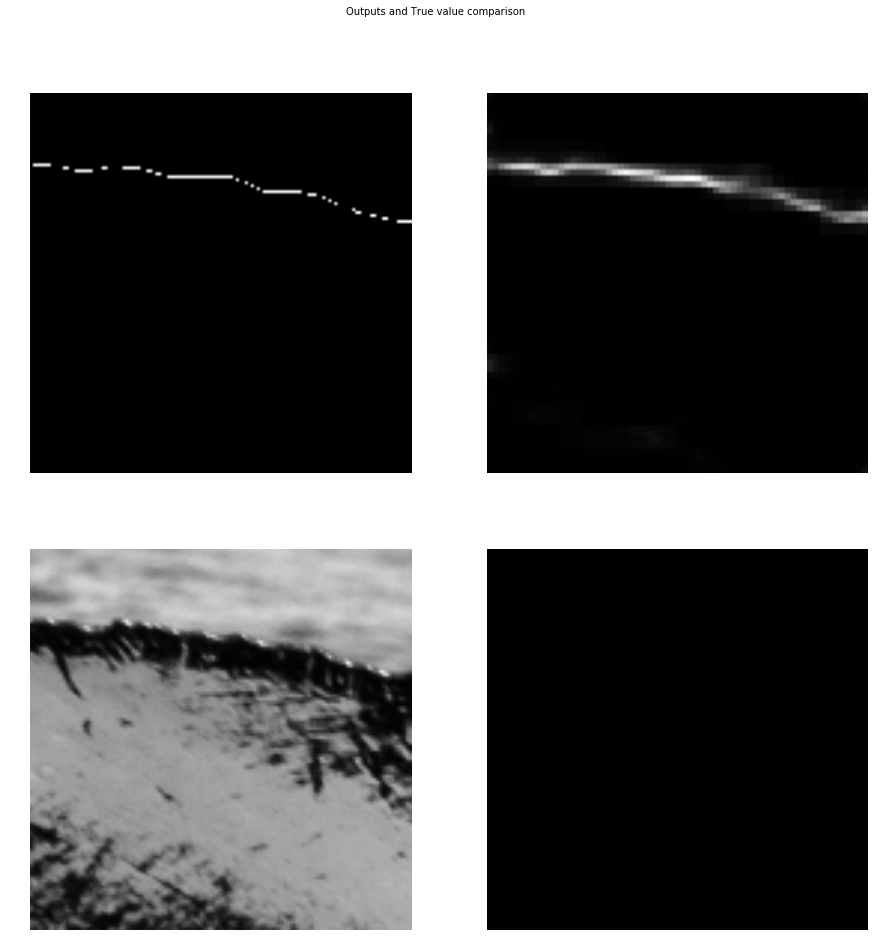

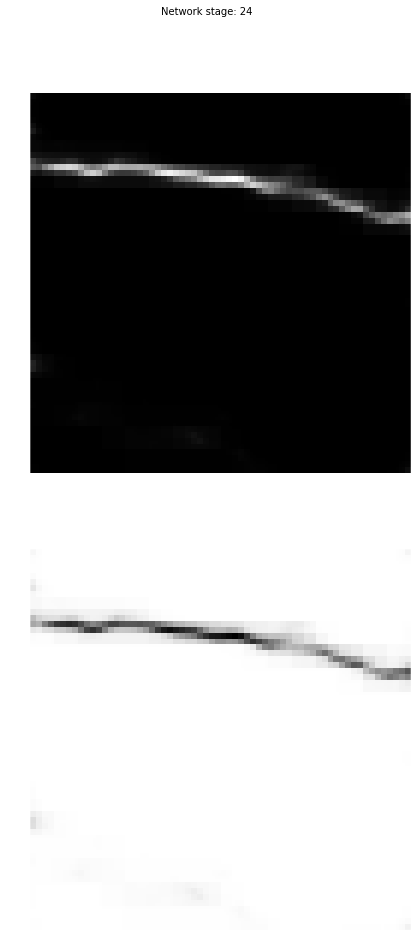

In [18]:


def show_output(originals, true_labels, outputs, ind, stage=-1, weights=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dset_label = true_labels[ind][0,:,:] # only show the trailing edge label
    
    pred_label = outputs[-1][ind]
    network_stage = outputs[stage][ind].swapaxes(0,2)
    plt.gray()
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    f.suptitle("Outputs and True value comparison")
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(dset_label)
    trueax[0,1].imshow(pred_label[0,:,:])
    trueax[1,0].imshow(dset_img)
    #trueax[1,1].imshow(weights[ind])
    trueax[1,1].imshow(np.argmax(pred_label,axis=0))
    
    nfilters = network_stage.shape[-1]
    if nfilters > 1:  
        square_size = int(np.sqrt(nfilters) + 0.5)
        ncols = square_size
        nrows = ncols + int((square_size % nfilters > 0))
    else:
        square_size = 1
    print(network_stage)
    plt.gray()
    if nfilters > 1:
        f, netax = plt.subplots(nrows, ncols, figsize=(15,15))
        if len(netax.shape) == 1:
            # fucking hell matplotlib
            netax = netax.reshape(-1,1)
        f.suptitle('Network stage: %d' % stage)

        for i, j in product(range(nrows), range(ncols)):
            this_ax = netax[i, j]
            this_ax.axis('off')
            #this_ax.get_xaxis().set_visible(False)
            #this_ax.get_yaxis().set_visible(False)
            #print(i)
            if i < nfilters:
                this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    else:
        # probably an input or stn
        #print(network_stage[:,:,0])
        #print(outputs[stage-1][ind].reshape(2,3))
        denormed =  (dset['std']*network_stage[:,:,0] + dset['mean']).astype(np.uint8).T
        #denormed = network_stage[:,:,0].astype(np.uint8)
        #print(denormed)

        f, netax = plt.subplots(1, figsize=(7.5,7.5))
        netax.axis('off')
        netax.imshow(denormed, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'valid'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=24, weights=dset_for_model[sec]['pixelw'])

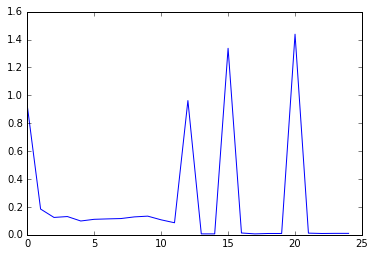

In [9]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])

0.0103211
0.0171012


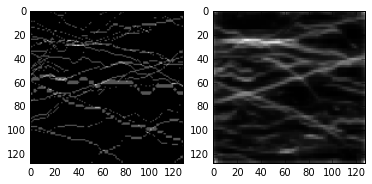

In [10]:
avg_label = np.average(dset_for_model[sec]['y'],axis=0)
avg_pred = np.average(point_outputs[sec][-1],axis=0)
f, ax = plt.subplots(1, 2)
ax[0].imshow(avg_label[0,:,:])
ax[1].imshow(avg_pred[0,:,:])

print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

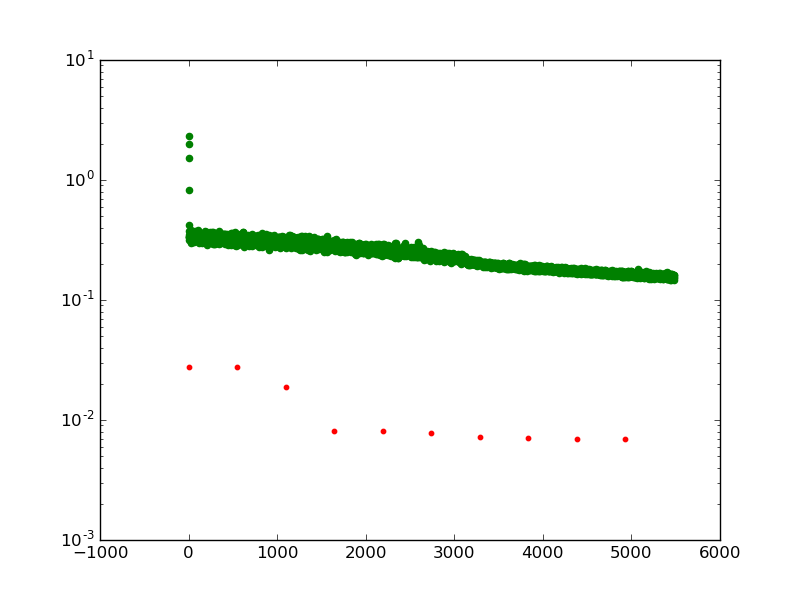

In [11]:
from IPython.display import Image 
Image(filename='./losses.png')

(1, 2, 2736, 3648)
(2736, 3648)


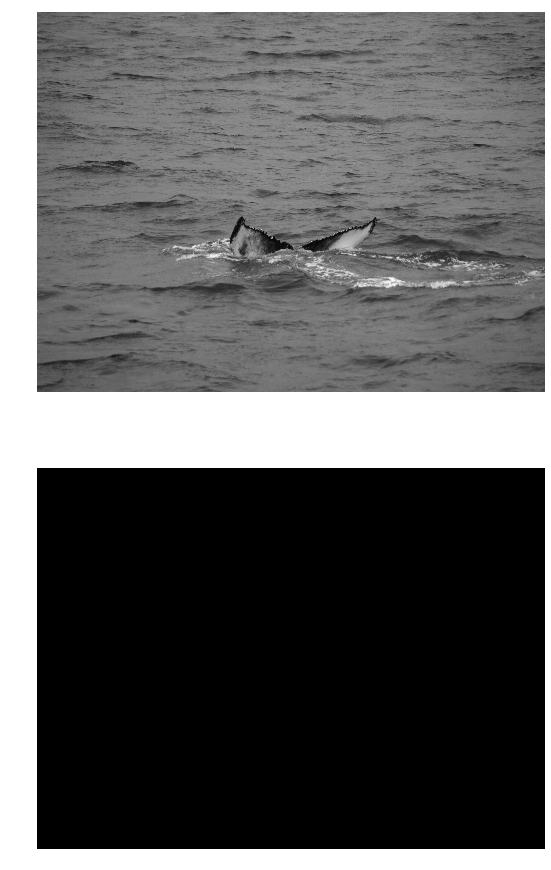

In [24]:
# Let's visualize a random image
imgs_dir = join(dataset_loc, 'Flukes/Flukebook/images')
import glob
zsl_imgs = glob.glob(join(imgs_dir, '*'))
rand_img = cv2.cvtColor(cv2.imread(random.choice(zsl_imgs)),cv2.COLOR_BGR2GRAY)
rand_img = (rand_img.astype(np.float32) - dset['mean']) / dset['std']
output_img = segmenter_fn(rand_img[np.newaxis,np.newaxis,:,:])[-1]
print(output_img.shape)
print(rand_img.shape)
f, ax = plt.subplots(2, figsize=(15,15))
[i.axis('off') for i in ax]
plt.gray()
ax[0].imshow(rand_img)
ax[1].imshow(output_img[0,0,:,:] > 0.9)


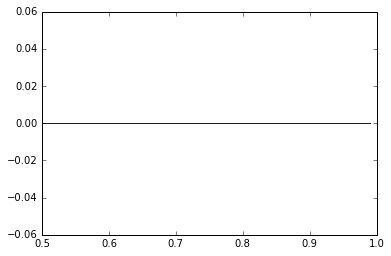

In [13]:
# false positive rate
def precision_recall(true, pred, pos_thresh=0.5):
    # given a set of predicted labels and true labels, figure out what the rate of false positive to true
    # positives is
    # assume decision axis is axis 1
    thresh = lambda x: x[:,0,:,:] > pos_thresh # this makes sense
    thresh_true = thresh(true)
    thresh_pred = thresh(pred)
    # now it's 0 where there's bg, and 1 where there's te
    # if we subtract true from pred, we'll have -1 for a false neg and 1 for a false pos
    n_tp = np.sum(np.logical_and(thresh_true, thresh_pred))
    n_tn = np.sum(1 - np.logical_and(thresh_true, thresh_pred))
    n_fp = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) > 0)
    n_fn = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) < 0)
    precision = (n_tp) / (n_tp + n_fp)
    recall = (n_tp) / (n_fn + n_tp)
    return precision, recall

thresholds = np.linspace(0.5,.99,10)
pr_curve = [precision_recall(dset_for_model[sec]['y'], point_outputs[sec][-1], pos_thresh=i) for i in thresholds]
plt.plot(thresholds, zip(*pr_curve)[0], color='r')
plt.plot(thresholds, zip(*pr_curve)[1], color='b')

In [14]:
# all bg accuracy?
np.sum(dset_for_model[sec]['y'][:,0,:,:] == np.zeros(dset_for_model[sec]['y'][:,0,:,:].shape,dtype=np.int)) / np.product(dset_for_model[sec]['y'][:,0,:,:].shape)

0.99794292449951172

In [15]:
# Export model params and dataset so that IBEIS can use it
model_ibs = {'params':model, 'mean':dset['mean'], 'std':dset['std']}
prod_model_name = 'tescorer_weights.pickle'
prod_model_dir = '/media/hdd/PUBLIC/models'
ut.save_cPkl(join(prod_model_dir, prod_model_name), model_ibs)
print(model_ibs['mean'])

[util_io] * save_cPkl(u'.../models/tescorer_weights.pickle', data)
131.637681961


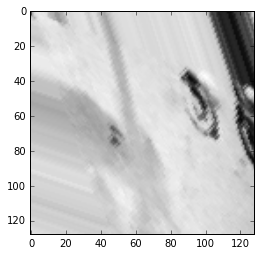

In [16]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))

In [17]:
dset_for_model[sec]['X'][0][0]

array([[-0.11655835,  0.32600957,  0.46335825, ..., -1.45952308,
        -1.45952308, -1.38321829],
       [-0.11655835,  0.34127054,  0.43283632, ..., -1.41374016,
        -1.44426215, -1.36795735],
       [-0.10129739,  0.1886609 ,  0.43283632, ..., -1.29165244,
        -1.39847922, -1.3526963 ],
       ..., 
       [ 0.43283632,  0.46335825,  0.43283632, ..., -0.25390702,
        -0.60490918, -0.89486748],
       [ 0.44809729,  0.46335825,  0.43283632, ...,  0.05131224,
        -0.37599471, -0.65069205],
       [ 0.44809729,  0.46335825,  0.43283632, ...,  0.15813898,
        -0.11655835, -0.26916799]], dtype=float32)